# Determine noise levels per patient per coil.

## Data Loading


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import h5py
from numpy.fft import fftshift, ifft2
import random
import SimpleITK as sitk
from typing import Dict, Any, List, Tuple
import scipy.ndimage
import sqlite3


# shape of the data: (averages, slices, coils, rows, columns)
def load_patient_data(patient_dict: dict, debug=False) -> dict:
    """
    Loads the k-space and reconstruction data for a given patient from the h5 file.
    
    Args:
    - patient_dict (dict): Dictionary containing the necessary paths and indices for the patient.
    
    Returns:
    - patient_dict (dict): The updated dictionary containing loaded data.
    """
    with h5py.File(patient_dict["h5_path"], 'r') as f:
        print(f"\nLoaded data for {patient_dict['h5_path']}")

        patient_dict["kspace"] = f['kspace'][:]
        patient_dict["slice_ksp"] = patient_dict["kspace"][patient_dict["avg_idx"], 
                                                          patient_dict["slice_idx"], 
                                                          patient_dict["coil_idx"], ...]
        print(f"Slice ksp shape: {patient_dict['slice_ksp'].shape}")
        
        # Optional: Convert to image space (inverse FFT)
        patient_dict["slice_img"] = np.fft.ifft2(patient_dict["slice_ksp"])
        
        if debug:
            for key in f.keys():
                print(key)
            for attr in f.attrs:
                print(attr, f.attrs[attr])

        # Debug: Print the shape and dtype of the k-space data
        print(f"\nkspace Shape: {patient_dict['kspace'].shape}")
        print(f"kspace dtpe: {patient_dict['kspace'].dtype}")
        
    return patient_dict


tmpdir = Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp')
print(tmpdir)

/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp


In [12]:
pat3 = {
    "h5_path": Path("/scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/h5s/meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2.h5"),
    "pat_id": "0003_umcg_pst_ksps",
    "kspace": None,
    "slice_idx": 15,          
    "avg_idx": 0,                 #  0: first avg, 1: second avg, 2: third avg
    "coil_idx": 0,                #  0: first coil, 1: second coil, 2: third coil etc .. 19: last coil
    "slice_ksp": None,            # The slice data from the kspace
    "slice_img": None,            # The slice data from the recon
}
pat4 = {
    "h5_path": "/scratch/p290820/datasets/003_umcg_pst_ksps/data/0004_ANON9616598/h5s/meas_MID00460_FID707792_T2_TSE_tra_obl-out_2.h5",
    "pat_id": "0004_ANON9616598",
    "kspace": None,
    "slice_idx": 15,          
    "avg_idx": 0,                 #  0: first avg, 1: second avg, 2: third avg
    "coil_idx": 0,                #  0: first coil, 1: second coil, 2: third coil etc .. 19: last coil
    "slice_ksp": None,            # The slice data from the kspace
    "slice_img": None,            # The slice data from the recon
}

pat3 = load_patient_data(pat3, debug=True)
pat4 = load_patient_data(pat4, debug=True)


Loaded data for /scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/h5s/meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2.h5
Slice ksp shape: (768, 651)
ismrmrd_header
kspace
acq_mat_dcm_hdr [  0 384 307   0]
acquisition AXT2
cols_dcm_hdr 768
do_norm_to_ref True
do_rm_zero_pad True
max 0.0004
max_phase_crop None
n_averages_dcm_hdr 3.0
n_phase_enc_steps_dcm_hdr 651
norm 0.12
pat_pos_dcm_hdr HFS
patient_id ANON5046358
patient_id_seq 0003
percent_phase_fov_dcm_hdr 100.0
percent_sampling_dcm_hdr 80.0
pixel_spacing_dcm_hdr [0.234375 0.234375]
rows_dcm_hdr 768

kspace Shape: (3, 30, 20, 768, 651)
kspace dtpe: complex64

Loaded data for /scratch/p290820/datasets/003_umcg_pst_ksps/data/0004_ANON9616598/h5s/meas_MID00460_FID707792_T2_TSE_tra_obl-out_2.h5
Slice ksp shape: (640, 551)
ismrmrd_header
kspace
acq_mat_dcm_hdr [  0 320 256   0]
acquisition AXT2
cols_dcm_hdr 640
do_norm_to_ref True
do_rm_zero_pad True
max 0.0004
max_phase_crop None
n_averages_dcm_hdr 3.0
n_phase_enc_step

## Collapsing Averages

In [9]:
def collapse_averages(kspace_data: np.ndarray) -> np.ndarray:
    """
    Collapse the averages in the k-space data.
    
    The input kspace_data must have shape (averages, slices, coils, rows, columns)
    with exactly 3 averages. The combination is performed as:
        combined_kspace = (avg1 + avg3) / 2 + avg2
    
    Args:
        kspace_data (np.ndarray): Complex k-space data.
        
    Returns:
        np.ndarray: Combined k-space data with shape (slices, coils, rows, columns).
    """
    assert isinstance(kspace_data, np.ndarray), "kspace_data must be a numpy array"
    assert kspace_data.ndim == 5, "Expected kspace_data to have 5 dimensions, got {}".format(kspace_data.ndim)
    assert kspace_data.shape[0] == 3, f"Expected 3 averages, got {kspace_data.shape[0]}"
    
    combined_kspace = ((kspace_data[0, ...] + kspace_data[2, ...]) / 2) + kspace_data[1, ...]
    return combined_kspace

In [ ]:
# lets add it to pat3 and pat4 as dict key and value
pat3["combined_kspace"] = collapse_averages(pat3["kspace"])
pat4["combined_kspace"] = collapse_averages(pat4["kspace"])

print(f"Combined k-space shape: {pat3['combined_kspace'].shape}")
print(f"Combined k-space shape: {pat4['combined_kspace'].shape}")

Combined k-space shape: (30, 20, 768, 651)
Combined k-space shape: (31, 26, 640, 551)


## Transform Kspace to Image Unitary

In [2]:
def transform_kspace_to_image_unitary(kspace_data: np.ndarray) -> np.ndarray:
    """
    Convert k-space data to image space using a unitary (energy-preserving) 2D inverse FFT.

    This function assumes the input k-space data has the shape:
        (slices, coils, rows, columns)
    It applies the following steps:
      1. Centers the k-space data using ifftshift.
      2. Performs a 2D inverse FFT with unitary normalization ('ortho').
      3. Centers the resulting image with fftshift.

    Using unitary normalization (norm='ortho') ensures that the FFT
    preserves the energy of the signal. In practical terms, if the k-space data
    includes additive Gaussian noise with a certain variance, then the noise
    level in the image space will be identical. This property is crucial for
    quantitative analysis and ensures that noise in k-space is directly related
    to noise in image space.

    Args:
        kspace_data (np.ndarray): K-space data array of shape 
                                  (slices, coils, rows, columns).

    Returns:
        np.ndarray: The image space data array with the same shape.
    """
    assert isinstance(kspace_data, np.ndarray), "kspace_data must be a numpy array"
    assert np.iscomplexobj(kspace_data), "kspace_data must be complex-valued"
    assert kspace_data.ndim == 4, f"Expected kspace_data to have 4 dimensions, got {kspace_data.ndim}"
    
    # 1. Center the k-space data along the spatial dimensions
    shifted_kspace = np.fft.ifftshift(kspace_data, axes=(-2, -1))
    
    # 2. Apply a 2D inverse FFT with unitary normalization to preserve noise levels.
    #    The 'ortho' normalization ensures that the energy (and thus the noise variance)
    #    in the k-space data is preserved in the image space.
    img_space = np.fft.ifft2(shifted_kspace, axes=(-2, -1), norm='ortho')
    
    # 3. Center the resulting image
    img_space = np.fft.fftshift(img_space, axes=(-2, -1))

    assert img_space.ndim == 4, f"Expected img_space to have 4 dimensions, got {img_space.ndim}"
    return img_space

In [ ]:
pat3["combined_img"] = transform_kspace_to_image_unitary(pat3["combined_kspace"])
pat4["combined_img"] = transform_kspace_to_image_unitary(pat4["combined_kspace"])

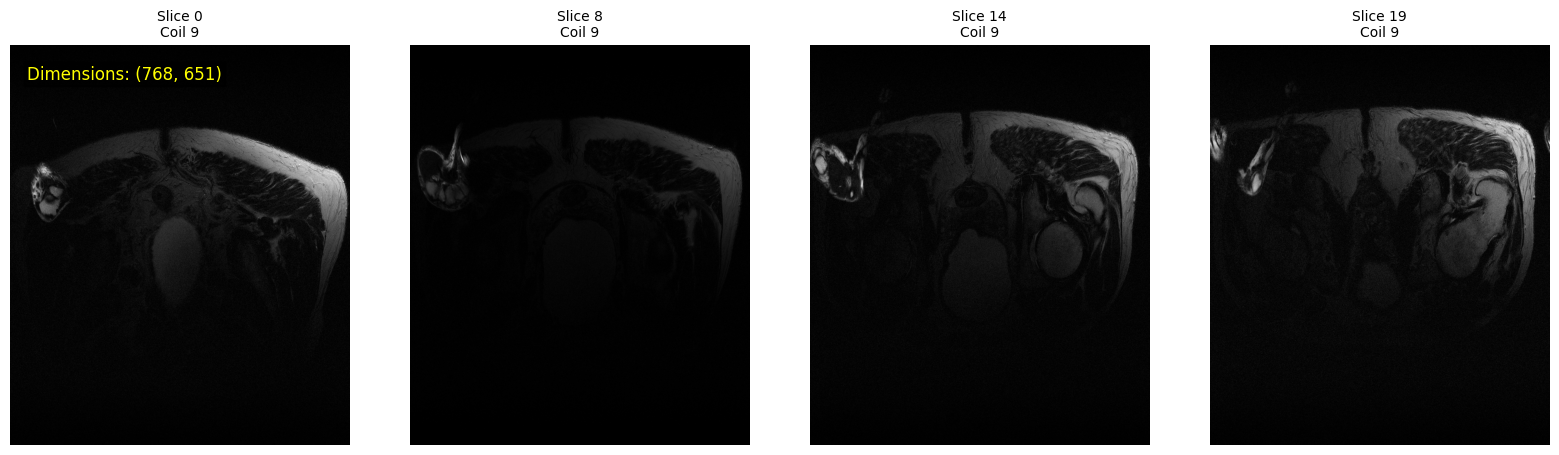

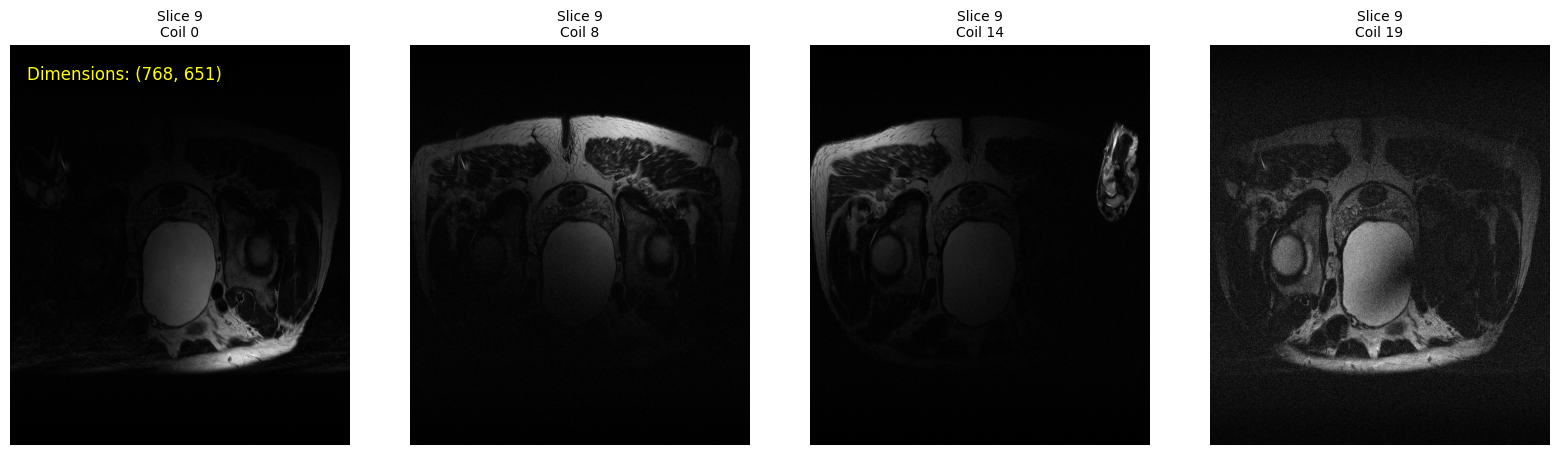

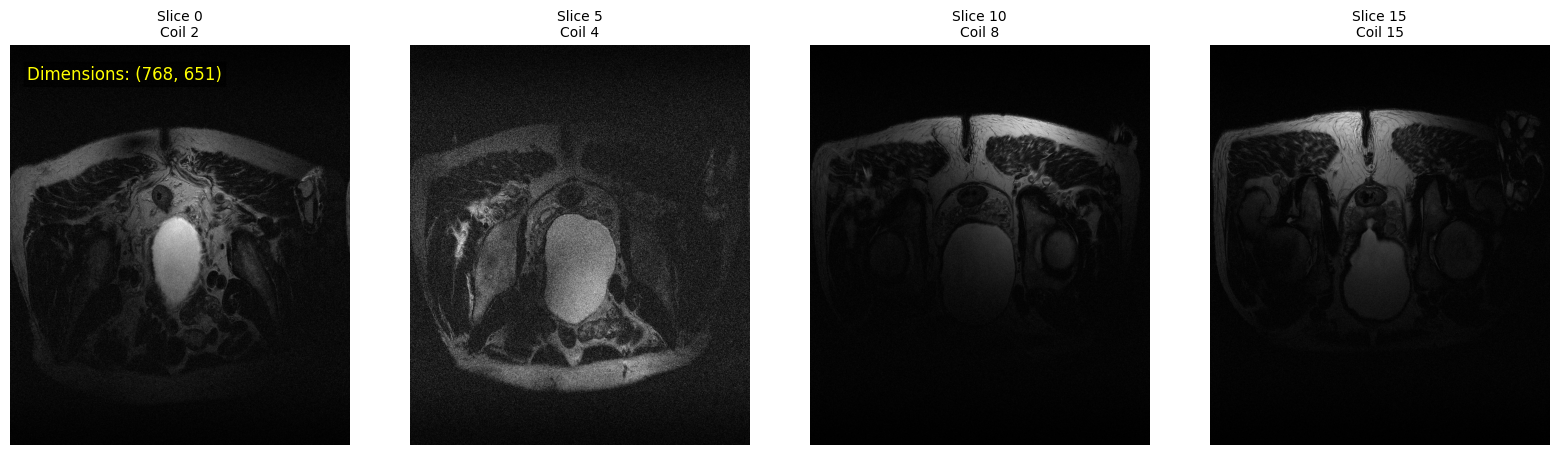

In [ ]:
def plot_slice_coil_pairs(img_array: np.ndarray, slice_indices: list, coil_indices: list, cmap: str = 'gray') -> None:
    """
    Plot a row of images, where each image is taken from the given slice and coil index pair.
    
    The image array is assumed to have the shape:
        (slices, coils, rows, columns)
    
    Args:
        img_array (np.ndarray): The image data array. of shape (slices, coils, rows, columns).
        slice_indices (list): List of slice indices.
        coil_indices (list): List of coil indices.
                              Both lists must be of the same length.
        cmap (str): Colormap for the images (default is 'gray').
    
    Raises:
        ValueError: If the length of slice_indices and coil_indices are not equal.
    
    Returns:
        None. Displays a matplotlib figure with the images.
    """
    if len(slice_indices) != len(coil_indices):
        raise ValueError("The lists for slice indices and coil indices must have the same length.")
    
    n_images = len(slice_indices)
    plt.figure(figsize=(4 * n_images, 4))
    
    for i, (s_idx, c_idx) in enumerate(zip(slice_indices, coil_indices)):
        ax = plt.subplot(1, n_images, i + 1)
        # Extract the image at the given slice and coil, and take the absolute value for display.
        img = np.abs(img_array[s_idx, c_idx])
        ax.imshow(img, cmap=cmap)
        ax.set_title(f"Slice {s_idx}\nCoil {c_idx}", fontsize=10)
        ax.axis('off')
        
        # For the leftmost image, add an annotation showing the image dimensions.
        if i == 0:
            dims = img.shape  # (rows, columns)
            ax.text(0.05, 0.95, f"Dimensions: {dims}", transform=ax.transAxes,
                    fontsize=12, color='yellow', verticalalignment='top',
                    bbox=dict(facecolor='black', alpha=0.5, pad=2))
    
    # Remove spacing between subplots.
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
    plt.show()

plot_slice_coil_pairs(pat3["combined_img"], slice_indices = [0, 8, 14, 19], coil_indices = [9, 9,  9, 9])
plot_slice_coil_pairs(pat3["combined_img"], slice_indices = [9, 9, 9 , 9 ], coil_indices = [0, 8, 14, 19])
plot_slice_coil_pairs(pat3["combined_img"], slice_indices = [0, 5, 10, 15], coil_indices = [2, 4, 8,  15])

## Determine noise levels in the background

In [ ]:
def estimate_noise_levels(img_array: np.ndarray, region_size: tuple = (32, 32), corner: str = 'ul') -> np.ndarray:
    """
    Estimate noise levels from a specified region in each slice and coil of the image array.
    
    The function selects a region of given size from one of the four corners of each image in the 4D array 
    (slices, coils, rows, columns) and computes the standard deviation of the magnitude (as a proxy for noise level).
    
    Args:
        img_array (np.ndarray): The image data array with shape (slices, coils, rows, columns). complex-valued.
        region_size (tuple): A tuple (n_rows, n_cols) specifying the size of the region to use for noise estimation.
        corner (str): Which corner to use for the noise estimation. Options are:
                      'ul' for upper left (default),
                      'ur' for upper right,
                      'll' for lower left,
                      'lr' for lower right.
    
    Returns:
        np.ndarray: An array of noise levels with shape (slices, coils), where each entry corresponds to the 
                    estimated noise level for that slice and coil.
    """
    slices, coils, rows, cols = img_array.shape
    noise_levels = np.zeros((slices, coils))
    
    n_rows, n_cols = region_size
    if n_rows > rows or n_cols > cols:
        raise ValueError("Region size is larger than the image dimensions.")
    
    # Iterate over each slice and coil
    for s in range(slices):
        for c in range(coils):
            # Use the magnitude in case the data is complex
            img = np.abs(img_array[s, c])
            if corner.lower() == 'ul':
                region = img[:n_rows, :n_cols]
            elif corner.lower() == 'ur':
                region = img[:n_rows, cols - n_cols:]
            elif corner.lower() == 'll':
                region = img[rows - n_rows:, :n_cols]
            elif corner.lower() == 'lr':
                region = img[rows - n_rows:, cols - n_cols:]
            else:
                raise ValueError("Invalid corner value. Use 'ul', 'ur', 'll', or 'lr'.")
            
            # Compute noise level as the standard deviation of the selected region
            noise_levels[s, c] = np.std(region)
    
    return noise_levels

# Example usage:
# Assuming 'pat3["combined_img"]' has shape (slices, coils, rows, cols)
# You can change 'corner' to 'ur', 'll', or 'lr' if you prefer a different area.
noise = estimate_noise_levels(pat3["combined_img"], region_size=(32, 32), corner='ul')

Window size of 250 results in specific peaks so is not good.
Window size of 150 results in specific peaks so is also not good.
Window size of 75 results in specific peaks so is also not good.
Window size of 50 results seems quite unifrom accors coils, therefore we will use this window size.


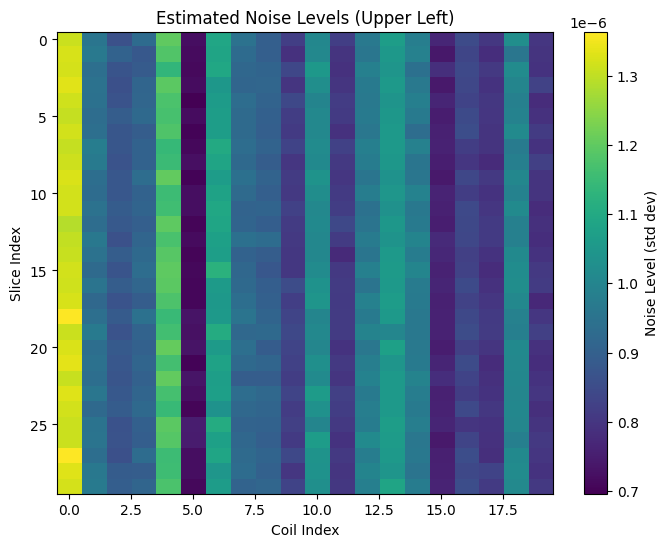

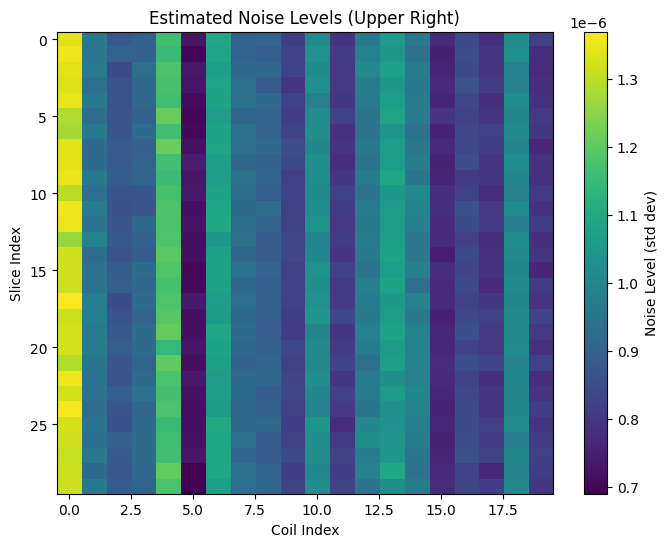

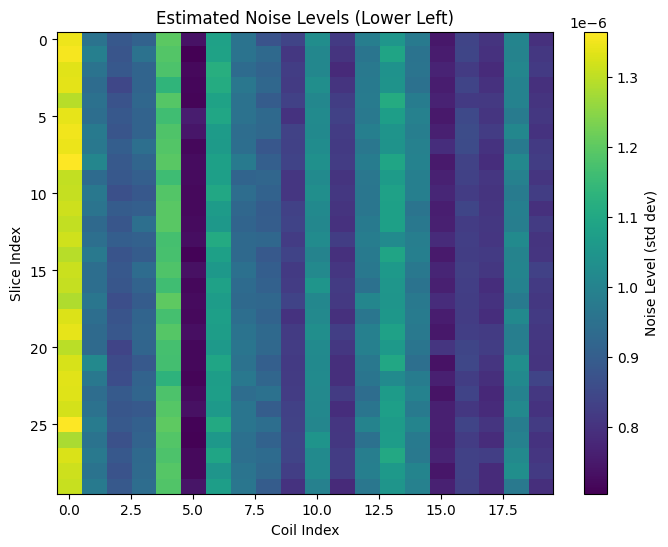

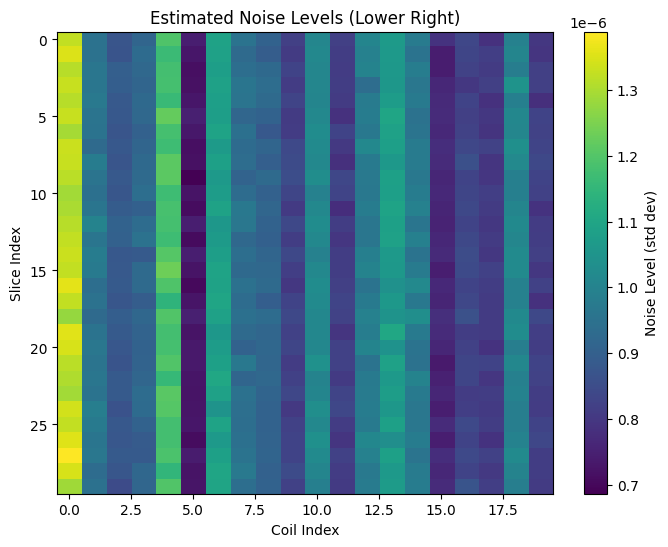

Mean noise level for upper left corner: 0.0000
[[1.30978378e-06 9.56403255e-07 8.60833950e-07 9.29677185e-07
  1.20090226e-06 7.21857361e-07 1.08979282e-06 9.47536250e-07
  8.96891095e-07 8.20406285e-07 1.00604018e-06 8.21063736e-07
  9.64622586e-07 1.06811251e-06 9.81586254e-07 7.67256836e-07
  8.48518312e-07 8.04339379e-07 1.02598972e-06 8.01656824e-07]
 [1.32217826e-06 9.65175445e-07 9.06079208e-07 8.78629578e-07
  1.18350397e-06 7.16233217e-07 1.08493361e-06 9.30097315e-07
  8.99312738e-07 7.91941545e-07 1.00820148e-06 7.96365327e-07
  9.57579346e-07 1.05101230e-06 9.89755449e-07 7.40375299e-07
  8.35861158e-07 7.84690485e-07 9.58841952e-07 7.97554208e-07]
 [1.32028288e-06 9.39736822e-07 8.70512622e-07 8.88801708e-07
  1.13405122e-06 7.12868598e-07 1.09307712e-06 9.18157184e-07
  9.11022710e-07 8.38077142e-07 1.05175957e-06 7.89970102e-07
  9.85851216e-07 1.04446428e-06 9.41530971e-07 7.85987368e-07
  8.42539578e-07 8.07071899e-07 1.01779233e-06 7.93754396e-07]
 [1.33302990e-06 9.4

In [ ]:
def visualize_noise_levels(noise_levels: np.ndarray, title: str = "Estimated Noise Levels"):
    """
    Visualize the noise levels array using a heatmap.
    
    Args:
        noise_levels (np.ndarray): Array of noise levels with shape (slices, coils).
        title (str): Title for the plot.
    
    Returns:
        None. Displays the heatmap.
    """
    plt.figure(figsize=(8, 6))
    # Create a heatmap of noise levels.
    im = plt.imshow(noise_levels, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar(im, label='Noise Level (std dev)')
    plt.xlabel('Coil Index')
    plt.ylabel('Slice Index')
    plt.title(title)
    plt.show()

# Example usage:
# Assuming 'pat3["combined_img"]' has shape (slices, coils, rows, cols)
ws = 50  # window size
noise_ul = estimate_noise_levels(pat3["combined_img"], region_size=(ws, ws), corner='ul')
noise_ur = estimate_noise_levels(pat3["combined_img"], region_size=(ws, ws), corner='ur')
noise_ll = estimate_noise_levels(pat3["combined_img"], region_size=(ws, ws), corner='ll')
noise_lr = estimate_noise_levels(pat3["combined_img"], region_size=(ws, ws), corner='lr')

print(f"Window size of 250 results in specific peaks so is not good.")
print(f"Window size of 150 results in specific peaks so is also not good.")
print(f"Window size of 75 results in specific peaks so is also not good.")
print(f"Window size of 50 results seems quite unifrom accors coils, therefore we will use this window size.")

visualize_noise_levels(noise_ul, title="Estimated Noise Levels (Upper Left)")
visualize_noise_levels(noise_ur, title="Estimated Noise Levels (Upper Right)")
visualize_noise_levels(noise_ll, title="Estimated Noise Levels (Lower Left)")
visualize_noise_levels(noise_lr, title="Estimated Noise Levels (Lower Right)")

print(f"Mean noise level for upper left corner: {np.mean(noise_ul):.4f}")
print(noise_ul)

## Compute the mean noise per coil over all slices of that coil and add to Database

### Create table for data

In [ ]:
def create_noise_estimation_table(db_path: Path):
    """
    Connects to the specified SQLite database, creates the 'noise_estimation' table if it doesn't exist,
    and logs the process using try/except blocks.

    The table includes the following columns:
        - id (TEXT)
        - seq_id (TEXT, NOT NULL)
        - anon_id (TEXT, NOT NULL)
        - h5_path (TEXT, NOT NULL)
        - noise_coils_list (TEXT, NOT NULL)
        - noise_corner (TEXT, NOT NULL)
        - noise_window_size (INTEGER, NOT NULL)
    
    Args:
        db_path (Path): Path to the SQLite database file.
    """
    conn = None
    try:
        print(f"Connecting to database at: {db_path}")
        conn = sqlite3.connect(str(db_path))
        c = conn.cursor()
        print("Database connection established.")

        # Define SQL query for creating the table.
        query = """
        CREATE TABLE IF NOT EXISTS noise_estimation (
            id TEXT,
            seq_id TEXT NOT NULL,
            anon_id TEXT NOT NULL,
            h5_path TEXT NOT NULL,
            noise_coils_list TEXT NOT NULL,
            noise_corner TEXT NOT NULL,
            noise_window_size INTEGER NOT NULL
        );
        """
        print("Creating table 'noise_estimation' (if it doesn't exist)...")
        c.execute(query)
        conn.commit()
        print("Table 'noise_estimation' created or already exists.")
    except sqlite3.Error as e:
        print(f"SQLite error occurred: {e}")
    except Exception as ex:
        print(f"An unexpected error occurred: {ex}")
    finally:
        try:
            if conn:
                conn.close()
                print("Database connection closed.")
        except Exception as close_ex:
            print(f"Error closing connection: {close_ex}")

Connecting to database at: /home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/databases/master_habrok_20231106_v2.db
Database connection established.
Creating table 'noise_estimation' (if it doesn't exist)...
Table 'noise_estimation' created or already exists.
Database connection closed.


In [ ]:
DO_MAKE_TABLE = False
if DO_MAKE_TABLE:
    db_path = Path("/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/databases/master_habrok_20231106_v2.db")
    create_noise_estimation_table(db_path)

## Add to database in order - Insert into the table

In [7]:
def load_kspace_data(h5_path: Path, debug: bool = True) -> np.ndarray:
    """
    Load the k-space data from a given .h5 file.
    
    Args:
        h5_path (Path): Path to the .h5 file.
        debug (bool): If True, prints debugging information (keys, attributes, shape, and dtype).
    
    Returns:
        np.ndarray: The k-space data loaded from the file.
    """
    with h5py.File(h5_path, 'r') as f:
        if debug:
            print(f"\nLoaded data for: {h5_path}")
            print("Dataset keys:")
            for key in f.keys():
                print(f"  {key}")
            print("File attributes:")
            for attr in f.attrs:
                print(f"  {attr}: {f.attrs[attr]}")
        
        kspace_data = f['kspace'][:]  # Load the entire 'kspace' dataset
        
        if debug:
            print(f"\nkspace shape: {kspace_data.shape}")
            print(f"kspace dtype: {kspace_data.dtype}")
    
    return kspace_data


def process_patient(patient_id: str, seq_id: str, anon_id: str, h5_path: Path, noise_corner: str, 
                    noise_window_size: tuple, db_path: Path, debug: bool = True) -> None:
    """
    Process a patient by loading the k-space data, collapsing the averages, estimating noise levels,
    and updating the noise_estimation table in the database.
    
    Steps:
    1. Check if the patient (by h5_path) already has a noise estimation entry in the database.
    2. If not, load k-space data, collapse averages, and estimate noise.
    3. Compute the mean noise per coil (averaging over slices).
    4. Insert a new record into the database.
    
    Args:
        patient_id (str): Unique identifier for the patient.
        seq_id (str): Sequence ID for the acquisition.
        anon_id (str): Anonymized patient ID.
        h5_path (Path): Path to the patient's .h5 file.
        noise_corner (str): Corner used for noise estimation ('ul', 'ur', 'll', or 'lr').
        noise_window_size (tuple): Region size (n_rows, n_cols) for noise estimation.
        db_path (Path): Path to the SQLite database.
        debug (bool): If True, prints debug messages.
    """
    conn = None
    try:
        print(f"\nProcessing patient {patient_id} with file: {h5_path}")
        conn = sqlite3.connect(str(db_path))
        c = conn.cursor()
        
        # Check if this patient (by h5_path) already has a noise estimation entry
        query_check = "SELECT COUNT(*) FROM noise_estimation WHERE h5_path = ?"
        c.execute(query_check, (str(h5_path),))
        count = c.fetchone()[0]
        if count > 0:
            print(f"Patient {patient_id} already has noise entry. Skipping.")
            return
        
        # 1. Load k-space data
        kspace_data = load_kspace_data(h5_path, debug=debug)
        
        # 2. Collapse the averages (expects 3 averages)
        combined_kspace = collapse_averages(kspace_data)
        if debug:
            print(f"Collapsed kspace shape: {combined_kspace.shape}")
        
        # 3. Estimate noise levels (returns array of shape (slices, coils))
        noise_array = estimate_noise_levels(combined_kspace, region_size=noise_window_size, corner=noise_corner)
        if debug:
            print(f"Estimated noise array shape: {noise_array.shape}")
        
        # Compute mean noise per coil (averaging over slices)
        mean_noise_per_coil = np.mean(noise_array, axis=0)  # shape: (coils,)
        if debug:
            print(f"Mean noise per coil: {mean_noise_per_coil}")
        
        # Convert the noise list to a comma-separated string
        noise_coils_list = ','.join(map(str, mean_noise_per_coil))
        
        # For noise_window_size, store one integer (assume square window, so take first dimension)
        noise_window_size_int = noise_window_size[0]
        
        # Insert new record into the database
        query_insert = """
        INSERT INTO noise_estimation (id, seq_id, anon_id, h5_path, noise_coils_list, noise_corner, noise_window_size)
        VALUES (?, ?, ?, ?, ?, ?, ?)
        """
        c.execute(query_insert, (patient_id, seq_id, anon_id, str(h5_path), noise_coils_list, noise_corner, noise_window_size_int))
        conn.commit()
        print(f"Noise estimation for patient {patient_id} inserted successfully.")
        
    except Exception as e:
        print(f"Error processing patient {patient_id}: {e}")
    finally:
        if conn:
            conn.close()
            print("Database connection closed.")

In [ ]:
DO_FILL_NOISE_TABLE = False
if DO_FILL_NOISE_TABLE:
    db_path = Path("/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/databases/master_habrok_20231106_v2.db")
    root_data_path = Path("/scratch/p290820/datasets/003_umcg_pst_ksps/data/")
    fpath_inc_ids = Path("/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/lists/inclusion/include_ids_sorted.lst")

    # Load the included patient IDs
    with open(fpath_inc_ids, "r") as f:
        inc_ids = [line.strip() for line in f.readlines()]
    print(f"Number of included patients: {len(inc_ids)}")
    print(f"First 5 included patients: {inc_ids[:5]}")

    # Define noise estimation parameters
    noise_window_size = (50, 50)  # Region size (rows, cols)

    # Loop over each patient
    for pat_id in inc_ids:
        pat_dir = root_data_path / pat_id
        h5_files = list(pat_dir.glob("h5s/*.h5"))
        print(f"\nPatient {pat_id} has {len(h5_files)} h5 files.")
        for h5_file in h5_files:
            # Here we use pat_id as the id
            process_patient(patient_id        = pat_id,
                            seq_id            = pat_id.split('_')[0],
                            anon_id           = pat_id.split('_')[1],
                            h5_path           = h5_file,
                            noise_corner      = 'ul',
                            noise_window_size = noise_window_size,
                            db_path           = db_path,
                            debug             = True)

Number of included patients: 120
First 5 included patients: ['0003_ANON5046358', '0004_ANON9616598', '0005_ANON8290811', '0006_ANON2379607', '0007_ANON1586301']

Patient 0003_ANON5046358 has 1 h5 files.

Processing patient 0003_ANON5046358 with file: /scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/h5s/meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2.h5

Loaded data for: /scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/h5s/meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2.h5
Dataset keys:
  ismrmrd_header
  kspace
File attributes:
  acq_mat_dcm_hdr: [  0 384 307   0]
  acquisition: AXT2
  cols_dcm_hdr: 768
  do_norm_to_ref: True
  do_rm_zero_pad: True
  max: 0.0004
  max_phase_crop: None
  n_averages_dcm_hdr: 3.0
  n_phase_enc_steps_dcm_hdr: 651
  norm: 0.12
  pat_pos_dcm_hdr: HFS
  patient_id: ANON5046358
  patient_id_seq: 0003
  percent_phase_fov_dcm_hdr: 100.0
  percent_sampling_dcm_hdr: 80.0
  pixel_spacing_dcm_hdr: [0.234375 0.234375]
  rows_dc

## So I accidentally added the arrays in format, so we must parse that again to an array format so we can use it in the vSHARP code
2.7052279814857426e-06,1.8145486852258078e-06,2.070486860767622e-06,1.9702517485192014e-06,1.9306205396268135e-06,2.0825236398585342e-06,2.7695051552914916e-06,1.8052981204164097e-06,2.6902516960295284e-06,2.279489574773054e-06,2.25870866675645e-06,1.7135895502308683e-06,2.738390302121323e-06,1.8230975326462483e-06,2.3379935815423126e-06,2.206976530162917e-06

In [ ]:
db_path = Path("/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/databases/master_habrok_20231106_v2.db")

# lets open the database and retrieve for the first patient the noise_coils_list
conn = sqlite3.connect(str(db_path))
c = conn.cursor()

query = "SELECT * FROM noise_estimation WHERE id = ?"
c.execute(query, ('0003_ANON5046358',))
id, seq_id, anon_id, h5_path, noise_coils_list, noise_corner, noise_wsize = c.fetchone()
print(type(noise_coils_list))
print(noise_coils_list)
conn.close()

<class 'str'>
2.954203409899492e-06,2.105457944405013e-06,1.955159802946582e-06,2.0381080048537116e-06,2.703345171539695e-06,1.6546109388097344e-06,2.474370110879439e-06,2.0995082953353023e-06,2.0432646427555786e-06,1.8526222409794475e-06,2.2865437964962136e-06,1.7862835875348537e-06,2.1720400127378525e-06,2.4040472074678595e-06,2.2003839376338875e-06,1.6823746932459472e-06,1.8690686336716074e-06,1.8116504710026978e-06,2.241600418528833e-06,1.8145307346154974e-06


In [5]:
# lets make a parser that parses the string with , 2.189615383451e-06 as a float list into an np.float array
def parse_noise_coils_list(noise_coils_list: str) -> np.ndarray:
    """
    Parse the noise_coils_list string into a numpy array of floats.
    
    Args:
        noise_coils_list (str): Comma-separated string of floats.
    
    Returns:
        np.ndarray: Array of floats.
    """
    # Split the string by commas and convert each element to a float.
    noise_list = [float(val) for val in noise_coils_list.split(',')]
    return np.array(noise_list)


# Example usage:
sigma_baseline = parse_noise_coils_list(noise_coils_list)
print(f"Noise levels per coil: {sigma_baseline}")
print(f"Type of the array: {type(sigma_baseline)}")
print(f"Shape: {sigma_baseline.shape}")
print(f"numpy dtype of the array: {sigma_baseline.dtype}")

Noise levels per coil: [2.95420341e-06 2.10545794e-06 1.95515980e-06 2.03810800e-06
 2.70334517e-06 1.65461094e-06 2.47437011e-06 2.09950830e-06
 2.04326464e-06 1.85262224e-06 2.28654380e-06 1.78628359e-06
 2.17204001e-06 2.40404721e-06 2.20038394e-06 1.68237469e-06
 1.86906863e-06 1.81165047e-06 2.24160042e-06 1.81453073e-06]
Type of the array: <class 'numpy.ndarray'>
Shape: (20,)
numpy dtype of the array: float64


## Lets do a Reconstruction without added noise for a patient
1. We do a reconstruction
2. We get the noise_levels per coil and add it to the k-space data with noise_multiplier of 2.5 for example
3. Compare both reconstructions.

In [10]:
print(h5_path)
kspace_data = load_kspace_data(h5_path, debug=False)
combined_kspace = collapse_averages(kspace_data)
print(f"Collapsed kspace shape: {combined_kspace.shape}")

/scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/h5s/meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2.h5
Collapsed kspace shape: (30, 20, 768, 651)


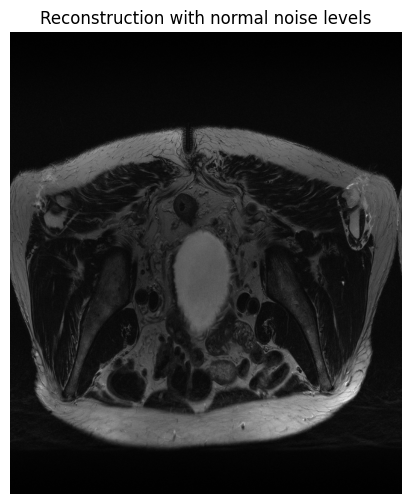

In [ ]:
# A - Recon with normal noise levels
recon_normal_coils = transform_kspace_to_image_unitary(combined_kspace)

# Collapse the coil dimension with the RSS method
recon_rss_normal = np.sqrt(np.sum(np.abs(recon_normal_coils)**2, axis=1))

# visualize with matplotlib
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(recon_rss_normal[0]), cmap='gray')
plt.title("Reconstruction with normal noise levels")
plt.axis('off')
plt.show()


# B - Recon with increased noise levels (additive noise) to the k-space data before reconstruction
noise_multiplier = 2.5
# Current k-space shape = (30, 20, 768, 651) -> slices, coils, rows, columns


Increased sigma per coil: [7.38550852e-06 5.26364486e-06 4.88789951e-06 5.09527001e-06
 6.75836293e-06 4.13652735e-06 6.18592528e-06 5.24877074e-06
 5.10816161e-06 4.63155560e-06 5.71635949e-06 4.46570897e-06
 5.43010003e-06 6.01011802e-06 5.50095984e-06 4.20593673e-06
 4.67267158e-06 4.52912618e-06 5.60400105e-06 4.53632684e-06]


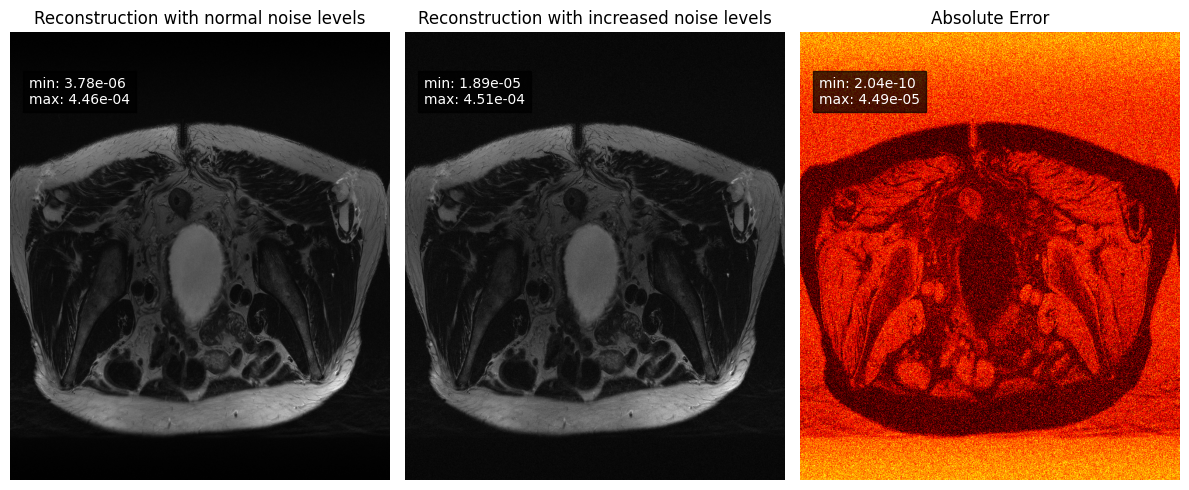

In [14]:
# Assume combined_kspace is already computed with shape (slices, coils, rows, cols)
# and noise_coils_list is a string retrieved from the database.

sigma_baseline = parse_noise_coils_list(noise_coils_list)
noise_multiplier = 2.5
sigma_increased = noise_multiplier * sigma_baseline
print("Increased sigma per coil:", sigma_increased)

# Create a new random generator for reproducibility:
rng = np.random.default_rng(42)

# Apply increased noise inline to the combined k-space data.
noisy_combined_kspace = np.empty_like(combined_kspace)
slices, coils, rows, cols = combined_kspace.shape

for s in range(slices):
    slice_data = combined_kspace[s].copy()  # shape: (coils, rows, cols)
    for c in range(coils):
        coil_data = slice_data[c]  # shape: (rows, cols)
        mask = np.nonzero(np.abs(coil_data) > 0)  # indices of measured (nonzero) lines
        if mask[0].size > 0:
            n_measured = mask[0].size
            noise = sigma_increased[c] * (rng.standard_normal(n_measured) + 1j * rng.standard_normal(n_measured))
            coil_data[mask] += noise
            slice_data[c] = coil_data
    noisy_combined_kspace[s] = slice_data

# Reconstruct both normal and noisy k-space data into image space.
recon_normal_coils = transform_kspace_to_image_unitary(combined_kspace)
recon_rss_normal = np.sqrt(np.sum(np.abs(recon_normal_coils)**2, axis=1))

recon_noisy_coils = transform_kspace_to_image_unitary(noisy_combined_kspace)
recon_rss_noisy = np.sqrt(np.sum(np.abs(recon_noisy_coils)**2, axis=1))

# C - VIZUALIZATION!!
# Calculate the absolute error between the two reconstructions.
error = np.abs(np.abs(recon_rss_normal[0]) - np.abs(recon_rss_noisy[0]))
error_min = np.min(error)
error_max = np.max(error)

fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Normal Reconstruction
ax = axs[0]
im0 = ax.imshow(np.abs(recon_rss_normal[0]), cmap='gray')
ax.set_title("Reconstruction with normal noise levels")
ax.axis('off')
ax.text(0.05, 0.90,
        f"min: {np.min(np.abs(recon_rss_normal[0])):.2e}\nmax: {np.max(np.abs(recon_rss_normal[0])):.2e}",
        transform=ax.transAxes,
        color='white', fontsize=10,
        verticalalignment='top',
        bbox=dict(facecolor='black', alpha=0.7))

# Noisy Reconstruction
ax = axs[1]
im1 = ax.imshow(np.abs(recon_rss_noisy[0]), cmap='gray')
ax.set_title("Reconstruction with increased noise levels")
ax.axis('off')
ax.text(0.05, 0.90,
        f"min: {np.min(np.abs(recon_rss_noisy[0])):.2e}\nmax: {np.max(np.abs(recon_rss_noisy[0])):.2e}",
        transform=ax.transAxes,
        color='white', fontsize=10,
        verticalalignment='top',
        bbox=dict(facecolor='black', alpha=0.7))

# Absolute Error Map with Annotation
ax = axs[2]
im2 = ax.imshow(error, cmap='hot')
ax.set_title("Absolute Error")
ax.axis('off')
ax.text(0.05, 0.90,
        f"min: {error_min:.2e}\nmax: {error_max:.2e}",
        transform=ax.transAxes,
        color='white', fontsize=10,
        verticalalignment='top',
        bbox=dict(facecolor='black', alpha=0.7))

plt.tight_layout()
plt.show()

# Clean the database for

In [ ]:
# close the connection
db_path = Path("/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/databases/master_habrok_20231106_v2.db")

# open the connection again
conn = sqlite3.connect(str(db_path))
c = conn.cursor()
query = "DELETE FROM patients_uq WHERE gaussian_id >0"
c.execute(query)
conn.commit()
conn.close()

